In [1]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm
import cv2

# Set the path to the image folders
path = "images/"

# Initialize empty lists to store the images and labels
x_data = []
y_data = []
global_path = "nouveau/images/train/"
# Iterate through the folders (disgust and surprise)
for i, class_folder in tqdm(enumerate([global_path+"disgust", global_path+"surprise",global_path+"angry",global_path+"fear",
                                 global_path+"happy",global_path+"neutral",global_path+"sad"])):
    for image_name in os.listdir(path + class_folder):
        # Open the image
        #img = Image.open(path + class_folder + '/' + image_name)
        img_data = cv2.imread(path + class_folder + '/' + image_name, cv2.IMREAD_GRAYSCALE)

        # Convert the image to a numpy array
        #img_data = np.array(img)
        # Append the image data and label to the lists
        x_data.append(img_data)
        y_data.append(i)
# Convert the lists to numpy arrays
x_data = np.array(x_data).astype(float)
y_data = np.array(y_data).astype(float)

# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.25, random_state=42,stratify=y_data,shuffle=True)
#x_train = x_train/255
#x_test = x_test/255


7it [00:05,  1.20it/s]


# Data augmentation:

In [2]:
from keras.preprocessing.image import ImageDataGenerator
x_train = x_train.reshape(-1, 48, 48, 1)
x_test = x_test.reshape(-1, 48, 48, 1)

data_gen_args = dict(rotation_range=10,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.2,
                     zoom_range=0.2,
                     horizontal_flip=True,
                     channel_shift_range=0,
                     fill_mode='nearest')
data_gen = ImageDataGenerator(**data_gen_args)
data_gen.fit(x_train)
x_train, y_train = next(data_gen.flow(x_train, y_train, batch_size=len(x_train)))
x_train = x_train.reshape(-1,48,48)

x_test, y_test = next(data_gen.flow(x_test, y_test, batch_size=len(x_test)))
x_test = x_test.reshape(-1,48,48)


In [3]:
x_train.shape

(26915, 48, 48)

In [4]:
import pandas as pd
pd.Series(y_train).value_counts()

4.0    6742
5.0    4648
6.0    4558
3.0    3841
2.0    3715
1.0    3001
0.0     410
dtype: int64

In [5]:
x_train.shape

(26915, 48, 48)

In [6]:
x_test.shape

(8972, 48, 48)

In [7]:
"""
from mtcnn import MTCNN
import matplotlib.pyplot as plt
import time

def facial_detector(im):
    detector = MTCNN()
    keys = detector.detect_faces(np.repeat(im[:, :, np.newaxis], 3, axis=2))
    print(keys)
    if len(keys) == 0:
        return np.zeros(15)
    keys=keys[0]
    keypoints_values = keys["box"]+[keys["confidence"]]+ [val for sublist in keys['keypoints'].values() for val in sublist]
    if len(keypoints_values)!=15:
        return np.zeros(15)
    return keypoints_values
start = time.time()

facial_train = list(tqdm(map(facial_detector, x_train[:20])))
#facial_test = list(map(facial_detector, x_test))

print(time.time()-start)
"""

'\nfrom mtcnn import MTCNN\nimport matplotlib.pyplot as plt\nimport time\n\ndef facial_detector(im):\n    detector = MTCNN()\n    keys = detector.detect_faces(np.repeat(im[:, :, np.newaxis], 3, axis=2))\n    print(keys)\n    if len(keys) == 0:\n        return np.zeros(15)\n    keys=keys[0]\n    keypoints_values = keys["box"]+[keys["confidence"]]+ [val for sublist in keys[\'keypoints\'].values() for val in sublist]\n    if len(keypoints_values)!=15:\n        return np.zeros(15)\n    return keypoints_values\nstart = time.time()\n\nfacial_train = list(tqdm(map(facial_detector, x_train[:20])))\n#facial_test = list(map(facial_detector, x_test))\n\nprint(time.time()-start)\n'

# pretrained model
## VGG16
**VGG16 expects the inputs to be 3-channel color and preprocessed (0..1)**

In [8]:
"""
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model

x_train_rgb = np.repeat(x_train[..., np.newaxis], 3, -1)
x_test_rgb = np.repeat(x_test[..., np.newaxis], 3, -1)

# Create a VGG16 model without the last fully connected layer
base_model = VGG16(weights='imagenet', include_top=False,pooling='avg', input_shape=(48, 48, 3))
#model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)
model = Model(inputs=base_model.input, outputs=base_model.output)

# Preprocess the images
x_train_preprocessed = preprocess_input(x_train_rgb)
x_test_preprocessed = preprocess_input(x_test_rgb)

# Extract features from the images
feature_1_train = model.predict(x_train_preprocessed)
feature_1_test = model.predict(x_test_preprocessed)
"""

"\nfrom keras.applications.vgg16 import VGG16\nfrom keras.applications.vgg16 import preprocess_input\nfrom keras.models import Model\n\nx_train_rgb = np.repeat(x_train[..., np.newaxis], 3, -1)\nx_test_rgb = np.repeat(x_test[..., np.newaxis], 3, -1)\n\n# Create a VGG16 model without the last fully connected layer\nbase_model = VGG16(weights='imagenet', include_top=False,pooling='avg', input_shape=(48, 48, 3))\n#model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)\nmodel = Model(inputs=base_model.input, outputs=base_model.output)\n\n# Preprocess the images\nx_train_preprocessed = preprocess_input(x_train_rgb)\nx_test_preprocessed = preprocess_input(x_test_rgb)\n\n# Extract features from the images\nfeature_1_train = model.predict(x_train_preprocessed)\nfeature_1_test = model.predict(x_test_preprocessed)\n"

## EfficientNetB0
**EfficientNet expects non scaled 3-channel images**

In [9]:
"""
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from keras.models import Model

x_train_rgb = np.repeat(x_train[..., np.newaxis], 3, -1)
x_test_rgb = np.repeat(x_test[..., np.newaxis], 3, -1)

# Create an EfficientNetB0 model without the last fully connected layer
base_model = EfficientNetB0(weights='imagenet', include_top=False,pooling='avg', input_shape=(48, 48,3))
model = Model(inputs=base_model.input, outputs=base_model.output)

# Extract features from the images
feature_1_train = model.predict(x_train_rgb)
feature_1_test = model.predict(x_test_rgb)
"""

"\nfrom tensorflow.keras.applications.efficientnet import EfficientNetB0\nfrom keras.models import Model\n\nx_train_rgb = np.repeat(x_train[..., np.newaxis], 3, -1)\nx_test_rgb = np.repeat(x_test[..., np.newaxis], 3, -1)\n\n# Create an EfficientNetB0 model without the last fully connected layer\nbase_model = EfficientNetB0(weights='imagenet', include_top=False,pooling='avg', input_shape=(48, 48,3))\nmodel = Model(inputs=base_model.input, outputs=base_model.output)\n\n# Extract features from the images\nfeature_1_train = model.predict(x_train_rgb)\nfeature_1_test = model.predict(x_test_rgb)\n"

## VGGface
for more information: https://github.com/rcmalli/keras-vggface

In [10]:
from keras_vggface.vggface import VGGFace
from keras_vggface import utils
from keras.models import Model

x_train_rgb = np.repeat(x_train[..., np.newaxis], 3, -1)
x_test_rgb = np.repeat(x_test[..., np.newaxis], 3, -1)


x_train_vgg = utils.preprocess_input(x_train_rgb, version=1)
x_test_vgg = utils.preprocess_input(x_test_rgb, version=1)
base_model = VGGFace(model='vgg16', include_top=False,pooling='avg', input_shape=(48, 48, 3))
model = Model(inputs=base_model.input, outputs=base_model.output)

# Extract features from the images
feature_1_train = model.predict(x_train_vgg)
feature_1_test = model.predict(x_test_vgg)


281/281 [==============================] - 8s 28ms/step


# Facial landmarks

In [11]:
import dlib
from imutils import face_utils

In [12]:
# the facial landmark predictor
p="shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(p)

In [16]:
x_train_shape = []

for im in tqdm(x_train):
    a = np.zeros((68,68))
    rects = detector(im.astype('uint8'), 1)
    if len(rects)==0:
        x_train_shape.append(a)
        continue
    shape = predictor(x_train[i].astype('uint8'),rects[0])
    shape = face_utils.shape_to_np(shape)
    a[shape.T[1],shape.T[0]]=255
    x_train_shape.append(a)
    
x_train_shape = np.array(x_train_shape)

100%|███████████████████████████████████████████████████████████████████████████| 26915/26915 [01:03<00:00, 426.07it/s]


In [17]:
x_test_shape = []
for im in tqdm(x_test):
    a = np.zeros((68,68))
    rects = detector(im.astype('uint8'), 1)
    if len(rects)==0:
        x_test_shape.append(a)
        continue
    shape = predictor(x_test[i].astype('uint8'),rects[0])
    shape = face_utils.shape_to_np(shape)
    a[shape.T[1],shape.T[0]]=255
    x_test_shape.append(a)
    
x_test_shape = np.array(x_test_shape)

100%|█████████████████████████████████████████████████████████████████████████████| 8972/8972 [00:23<00:00, 376.31it/s]


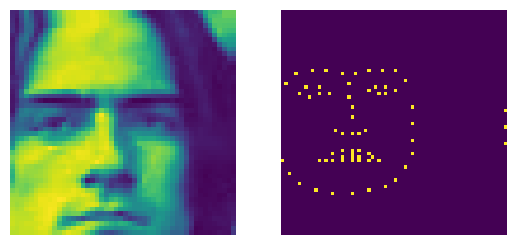

In [18]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2)

axs[0].imshow(x_train[6])
axs[0].axis("off")
axs[1].imshow(x_train_shape[6])
axs[1].axis("off")

# Show the figure
plt.show()

# local binary pattern and Histogram of Oriented Gradients extraction

In [19]:
from skimage.feature import local_binary_pattern, hog

# Initialize empty lists to store the features
lbp_train = []
hog_train = []
lbp_test = []
hog_test = []

# Extract LBP features from the training images
for img in x_train:
    lbp = local_binary_pattern(img, P=8, R=1, method='uniform')
    lbp_train.append(lbp.ravel())

# Extract HOG features from the training images
for img in x_train:
    hog_features = hog(img, orientations=4, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), visualize=False, multichannel=False)
    hog_train.append(hog_features)

# Extract LBP features from the test images
for img in x_test:
    lbp = local_binary_pattern(img, P=8, R=1, method='uniform')
    lbp_test.append(lbp.ravel())

# Extract HOG features from the test images
for img in x_test:
    hog_features = hog(img, orientations=4, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), visualize=False, multichannel=False)
    hog_test.append(hog_features)

# Convert the lists to numpy arrays
lbp_train = np.array(lbp_train)
hog_train = np.array(hog_train)
lbp_test = np.array(lbp_test)
hog_test = np.array(hog_test)

lbp_hog_train = np.hstack([hog_train,lbp_train])
lbp_hog_test = np.hstack([hog_test,lbp_test])


C:\Users\hamdi\AppData\Local\Temp\ipykernel_22520\1480635723.py:16: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  hog_features = hog(img, orientations=4, pixels_per_cell=(8, 8),
C:\Users\hamdi\AppData\Local\Temp\ipykernel_22520\1480635723.py:27: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  hog_features = hog(img, orientations=4, pixels_per_cell=(8, 8),


In [20]:
# stack all features all together

In [21]:
features_train = np.hstack([lbp_hog_train,feature_1_train])
features_test = np.hstack([lbp_hog_test,feature_1_test])

# Model

In [22]:
import keras
import tensorflow as tf
from keras.layers import Input, Dense, Flatten, concatenate, Conv2D, Dropout, MaxPooling2D, BatchNormalization
from keras.models import Model
from keras import regularizers


In [23]:
# data scaling
x_train = x_train/255
x_test = x_test/255
x_train_shape = x_train_shape/255
x_test_shape = x_test_shape/255

In [37]:
pd.DataFrame(x_train.reshape(x_train.shape[0],-1)).to_csv("x_train.csv",index=False)

In [38]:
pd.DataFrame(y_train.reshape(y_train.shape[0],-1)).to_csv("y_train.csv",index=False)
pd.DataFrame(x_test.reshape(x_test.shape[0],-1)).to_csv("x_test.csv",index=False)
pd.DataFrame(y_test.reshape(y_test.shape[0],-1)).to_csv("y_test.csv",index=False)

In [57]:
x_train = pd.read_csv("x_train.csv")
y_train = pd.read_csv("y_train.csv")
x_test = pd.read_csv("x_test.csv")
y_test = pd.read_csv('y_test.csv')

In [55]:
x_train.shape

(26915, 2304)

In [58]:
x_train = x_train.values.reshape(x_train.shape[0],48,48)
y_train = y_train.values
x_test = x_test.values.reshape(x_test.shape[0],48,48)
y_test = y_test.values


In [59]:
# Define the input layer
input_layer = Input(shape=(48, 48, 1))
input_layer_shape = Input(shape=(68,68,1))
input_layer_features = Input(shape=features_train.shape[1:])


# for images:
# Define 1st CNN architecture
x = Conv2D(64, (3, 3), activation='relu', padding='same',kernel_initializer='he_normal')(input_layer)
x= BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)

# Define 2nd CNN architecture
x = Conv2D(128, (3, 3), activation='relu', padding='same',kernel_initializer='he_normal')(x)
x= BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)

# Define 3rd CNN architecture
x = Conv2D(256, (4, 4), activation='relu', padding='same',kernel_initializer='he_normal')(x)
x= BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)

# Define 4th CNN architecture
x = Conv2D(512, (4, 4), activation='relu', padding='same',kernel_initializer='he_normal')(x)
x= BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)

# Flattening
x = Flatten()(x)

#for images shape:
# Define 1st CNN architecture
x_shape = Conv2D(64, (4, 4), activation='relu', padding='same',kernel_initializer='he_normal')(input_layer_shape)
x_shape= BatchNormalization()(x_shape)
x_shape = MaxPooling2D(pool_size=(3, 3))(x_shape)
x_shape = Dropout(0.2)(x_shape)

# Define 2nd CNN architecture
x_shape = Conv2D(128, (4, 4), activation='relu', padding='same',kernel_initializer='he_normal')(x_shape)
x_shape= BatchNormalization()(x_shape)
x_shape = MaxPooling2D(pool_size=(3, 3))(x_shape)
x_shape = Dropout(0.2)(x_shape)

x_shape = Flatten()(x_shape)

x_shape= Dense(128,activation='relu')(x_shape)
x_shape = BatchNormalization()(x_shape)
x_shape = Dropout(0.25)(x_shape)

# Concatenate the CNN output with the features output
output = concatenate([x,x_shape,input_layer_features])

#1st fully connected layer
output = Dense(256,activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.25)(output)

#2nd fully connected layer
output = Dense(512,activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.25)(output)


output = Dense(7,activation='softmax')(output)
model = keras.Model([input_layer,input_layer_shape,input_layer_features], output)

# Compile the model
model.compile(optimizer="Adam", loss='sparse_categorical_crossentropy',
               metrics=[tf.keras.metrics.SparseCategoricalAccuracy(),tf.keras.metrics.SparseCategoricalCrossentropy()])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d_12 (Conv2D)             (None, 48, 48, 64)   640         ['input_8[0][0]']                
                                                                                                  
 batch_normalization_18 (BatchN  (None, 48, 48, 64)  256         ['conv2d_12[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 max_pooling2d_12 (MaxPooling2D  (None, 24, 24, 64)  0           ['batch_normalization_18[0]

                                                                                                  
 dense_9 (Dense)                (None, 256)          2035968     ['concatenate_2[0][0]']          
                                                                                                  
 batch_normalization_25 (BatchN  (None, 256)         1024        ['dense_9[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 dropout_25 (Dropout)           (None, 256)          0           ['batch_normalization_25[0][0]'] 
                                                                                                  
 dense_10 (Dense)               (None, 512)          131584      ['dropout_25[0][0]']             
                                                                                                  
 batch_nor

In [60]:
# Train the model using fit()
history = model.fit(
    [x_train, x_train_shape,features_train],  # The datasets to use for training
    [y_train,y_train,y_train],    # The targets for each of the datasets
    epochs=10,            # The number of epochs to train for
    batch_size=16,
    #validation_data=[(XV,y_val),(XVal, y_val)])
    validation_split=0.2
)

Epoch 1/10
1346/1346 [==============================] - 79s 55ms/step - loss: 1.9525 - sparse_categorical_accuracy: 0.2717 - sparse_categorical_crossentropy: 1.9525 - val_loss: 1.6927 - val_sparse_categorical_accuracy: 0.3439 - val_sparse_categorical_crossentropy: 1.6927
Epoch 2/10
1346/1346 [==============================] - 71s 53ms/step - loss: 1.6152 - sparse_categorical_accuracy: 0.3829 - sparse_categorical_crossentropy: 1.6152 - val_loss: 1.5242 - val_sparse_categorical_accuracy: 0.4078 - val_sparse_categorical_crossentropy: 1.5242
Epoch 3/10
1346/1346 [==============================] - 71s 52ms/step - loss: 1.4489 - sparse_categorical_accuracy: 0.4503 - sparse_categorical_crossentropy: 1.4489 - val_loss: 1.5018 - val_sparse_categorical_accuracy: 0.4321 - val_sparse_categorical_crossentropy: 1.5018
Epoch 4/10
1346/1346 [==============================] - 71s 52ms/step - loss: 1.3348 - sparse_categorical_accuracy: 0.4936 - sparse_categorical_crossentropy: 1.3348 - val_loss: 1.4349 

In [62]:
y_pred= model.predict([x_test, x_test_shape,features_test], batch_size=32)


281/281 [==============================] - 6s 16ms/step


In [63]:
y_pred = np.argmax(y_pred,axis=1)

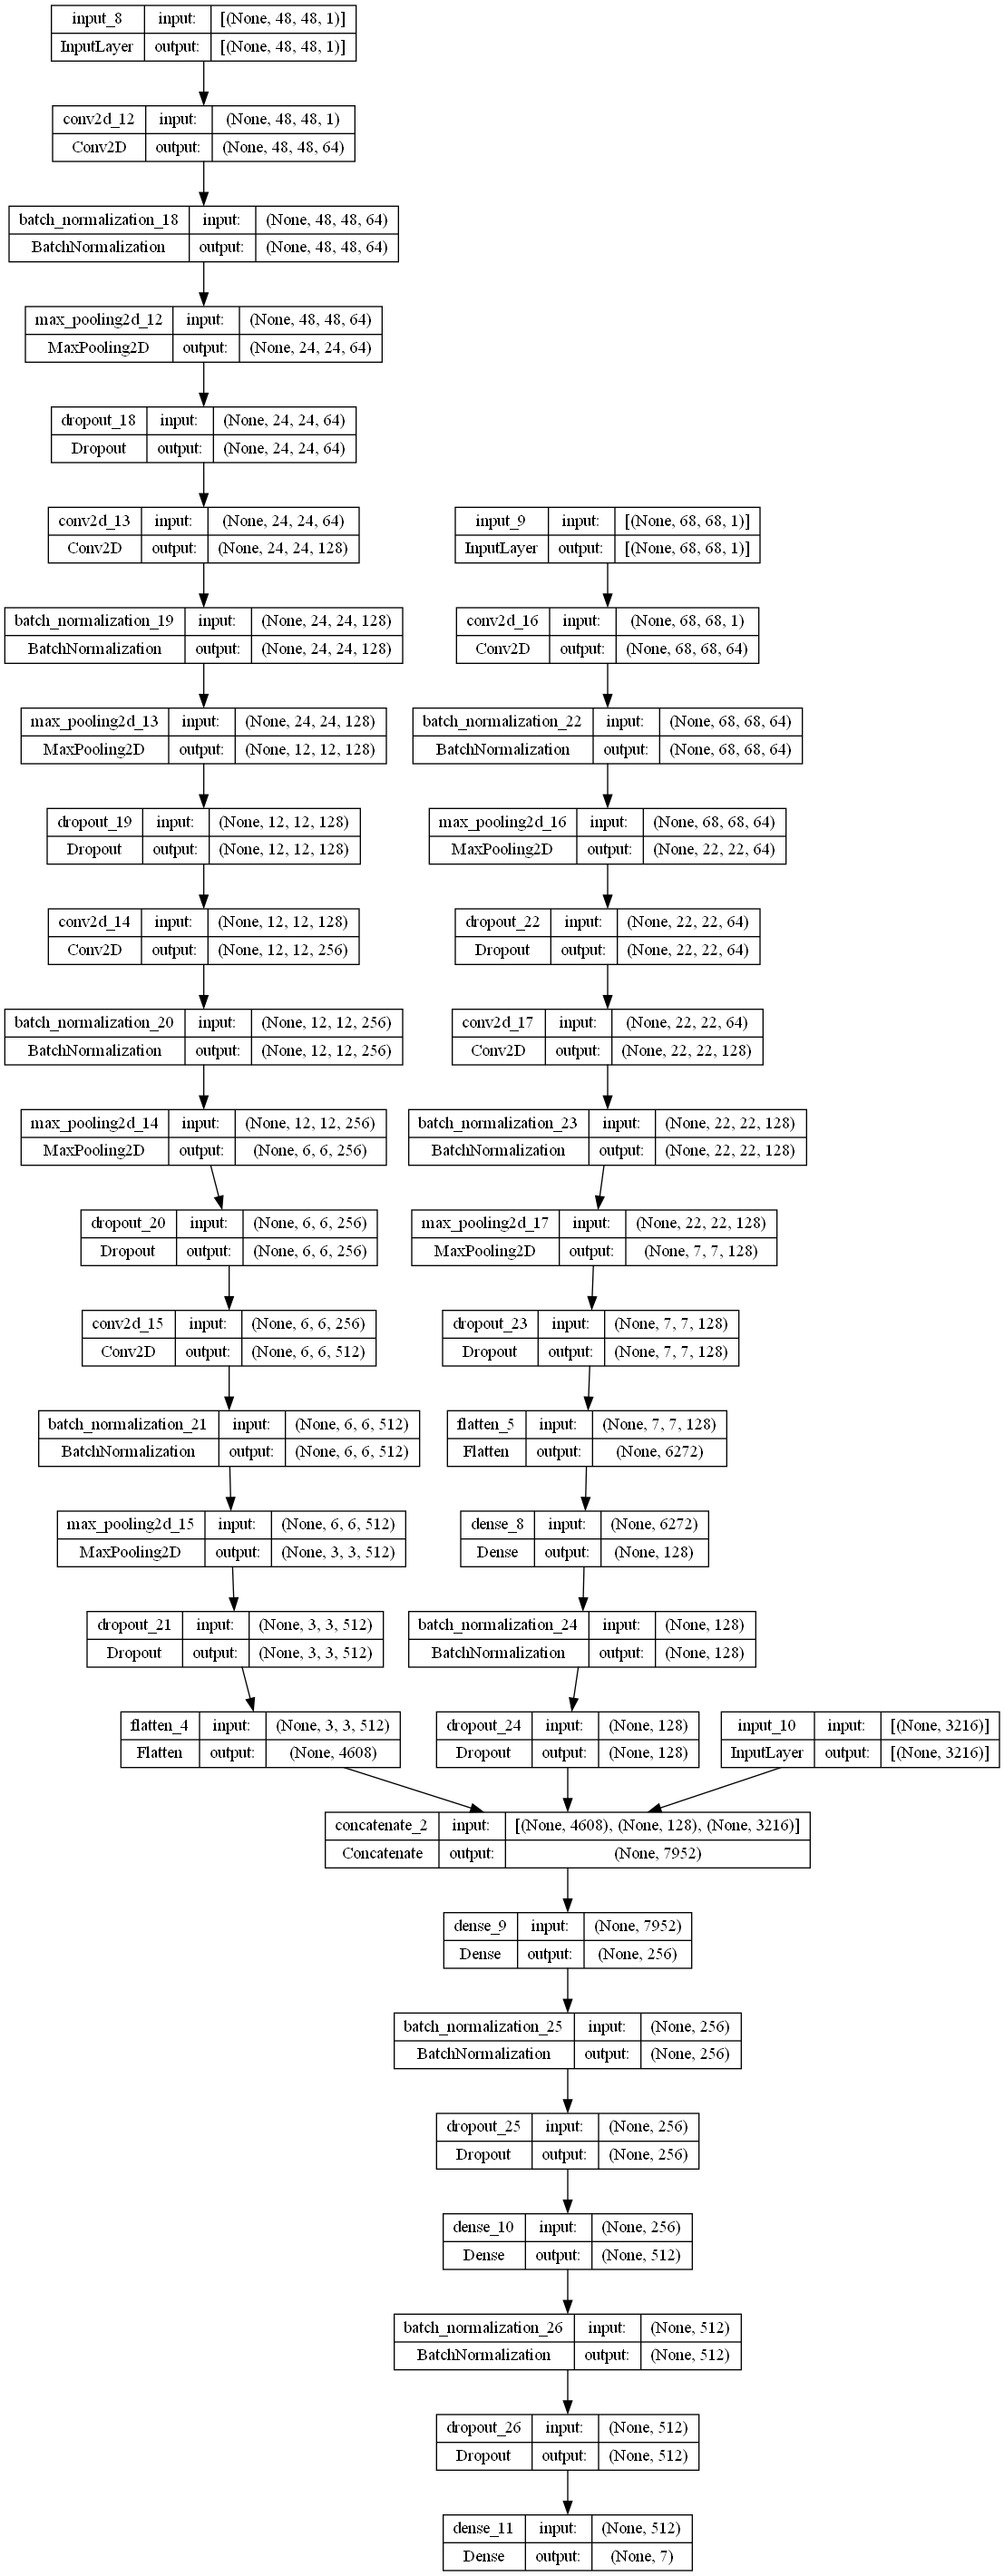

In [64]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [65]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.metrics import balanced_accuracy_score, accuracy_score, precision_score, recall_score, f1_score

In [109]:
print('\n------------------ Confusion Matrix -----------------\n')
print(confusion_matrix(y_test, y_pred))

print('\n-------------------- Key Metrics --------------------')
print('\nAccuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Balanced Accuracy: {:.2f}\n'.format(balanced_accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

print('\n--------------- Classification Report ---------------\n')
print(classification_report(y_test, y_pred))


------------------ Confusion Matrix -----------------

[[  35    4   36   13   13   12   24]
 [   5  613   63   92   84   97   47]
 [  61   46  508  114  100  198  211]
 [  28  150  212  304  106  224  256]
 [  24   55  117   66 1641  201  143]
 [  21   49  171   87  156  810  256]
 [  37   39  247  167  108  367  554]]

-------------------- Key Metrics --------------------

Accuracy: 0.50
Balanced Accuracy: 0.45

Micro Precision: 0.50
Micro Recall: 0.50
Micro F1-score: 0.50

Macro Precision: 0.44
Macro Recall: 0.45
Macro F1-score: 0.44

Weighted Precision: 0.50
Weighted Recall: 0.50
Weighted F1-score: 0.50

--------------- Classification Report ---------------

              precision    recall  f1-score   support

         0.0       0.17      0.26      0.20       137
         1.0       0.64      0.61      0.63      1001
         2.0       0.38      0.41      0.39      1238
         3.0       0.36      0.24      0.29      1280
         4.0       0.74      0.73      0.74      2247
   

In [21]:
import netron
model.save('model.h5')
netron.start('model.h5')

Serving 'model.h5' at http://localhost:8080


('localhost', 8080)

<AxesSubplot:>

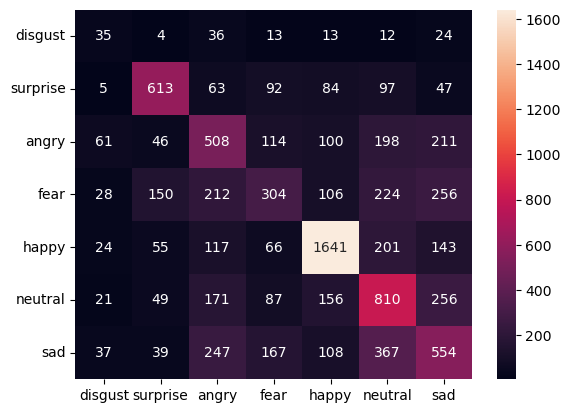

In [113]:
import seaborn as sns
emotions = {0:"disgust",1:"surprise",2:"angry",3:"fear",4:"happy",5:"neutral",6:"sad"}

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',xticklabels=emotions.values(), yticklabels=emotions.values())

Text(0.5, 1.0, 'precision_recall_curve')

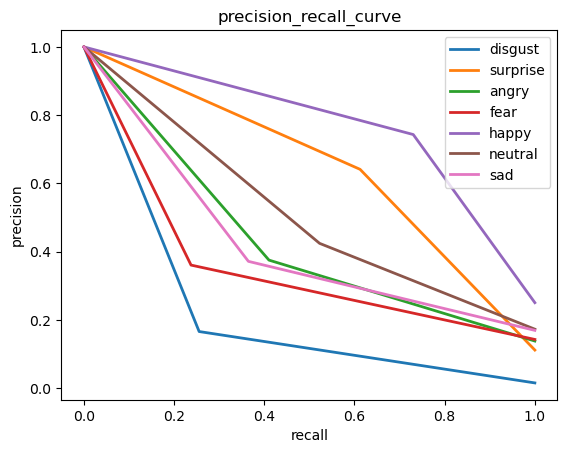

In [152]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score

y_pred1 = pd.Series(y_pred.reshape(y_pred.shape[0])).apply(lambda x: emotions[x])
y_test1 = pd.Series(y_test.reshape(y_test.shape[0])).apply(lambda x: emotions[x])

y_test1 = pd.get_dummies(y_test1,columns =emotions.values())
y_pred1 = pd.get_dummies(y_pred1, columns =emotions.values())
y_test1 = y_test1[emotions.values()]
y_pred1 = y_pred1[emotions.values()]
average_precision = {}
for label, emotion in emotions.items():
    precision, recall, _ = precision_recall_curve(y_test1.values[:, label], y_pred1.values[:, label])
    average_precision[label] = average_precision_score(y_test1.values[:, label], y_pred1.values[:, label])
    plt.plot(recall, precision, lw=2, label=emotion)
    

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision_recall_curve")

Text(0.5, 1.0, 'ROC_Curve')

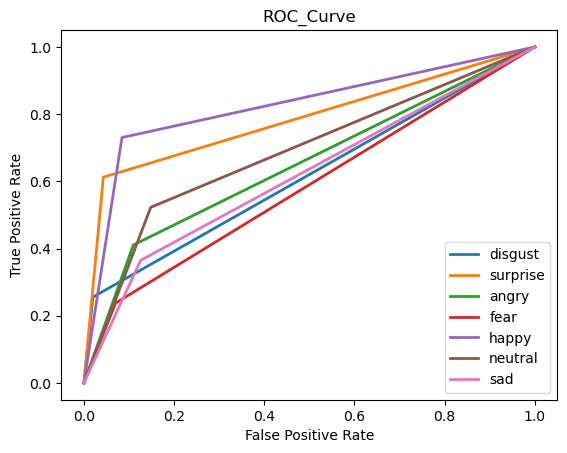

In [151]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr = dict()
tpr = dict()
roc_auc = dict()

for class_, emotion in emotions.items():
    fpr[class_], tpr[class_], _ = roc_curve(y_test1.values[:, class_], y_pred1.values[:, class_])
    roc_auc[class_] = auc(fpr[class_], tpr[class_])
    plt.plot(fpr[class_], tpr[class_], lw=2, label=emotion)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="best")
plt.title("ROC_Curve")
